1. Для примера я выберу открытый датасет — COVID-19 Dataset, содержащий данные о пандемии COVID-19.

In [224]:
import os
import logging
import pandas as pd
from save import save_to_csv
from my_logging import setup_logging
from data_loader import DataLoader
from visualization import DataVisualizer

# Настройка логирования
setup_logging()

# Инициализация DataLoader
loader = DataLoader()

# URL для загрузки данных
url = "https://github.com/owid/covid-19-data/raw/master/public/data/latest/owid-covid-latest.csv"

# Загрузка данных
data = pd.read_csv(url)

# Проверка данных
if data is not None and not data.empty:
    print(data.head())  # Вывод первых строк данных

    # Убедимся, что папка 'data' существует
    output_folder = "data"
    os.makedirs(output_folder, exist_ok=True)  # Создаёт папку, если её нет
    logging.info(f"Folder '{output_folder}' created.")

    # Полный путь к файлу
    output_file = os.path.join(output_folder, "covid_data.csv")

    # Сохранение данных с использованием save_to_csv
    save_to_csv(data.to_dict(orient="records"), output_file)
    logging.info(f"Data saved to {output_file}")
    print(f"Data saved to {output_file}")
else:
    logging.error("Failed to load data from the URL.")

   iso_code continent        location last_updated_date  total_cases  \
0       AFG      Asia     Afghanistan        2024-08-04     235214.0   
1  OWID_AFR       NaN          Africa        2024-08-04   13145380.0   
2       ALB    Europe         Albania        2024-08-04     335047.0   
3       DZA    Africa         Algeria        2024-08-04     272139.0   
4       ASM   Oceania  American Samoa        2024-08-04       8359.0   

   new_cases  new_cases_smoothed  total_deaths  new_deaths  \
0        0.0               0.000        7998.0         0.0   
1       36.0               5.143      259117.0         0.0   
2        0.0               0.000        3605.0         0.0   
3       18.0               2.571        6881.0         0.0   
4        0.0               0.000          34.0         0.0   

   new_deaths_smoothed  ...  male_smokers  handwashing_facilities  \
0                  0.0  ...           NaN                  37.746   
1                  0.0  ...           NaN               

2. Создадим новую базу данных в системе управления базами данных SQLite, используется библиотека sqlite3.

In [206]:
import sqlite3

# Подключаемся к SQLite (создаём файл базы данных)
conn = sqlite3.connect("covid_data.db")
cursor = conn.cursor()

3. Создадим таблицу в базе данных с различными типами данных (INTEGER, TEXT, DATE).

In [207]:
# Создаём таблицу для данных
cursor.execute("""
CREATE TABLE IF NOT EXISTS covid_data (
    iso_code TEXT,
    continent TEXT,
    location TEXT,
    date DATE,
    total_cases INTEGER,
    new_cases INTEGER,
    total_deaths INTEGER,
    new_deaths INTEGER,
    population INTEGER
)
""")
conn.commit()
print("Таблица создана.")

Таблица создана.


In [208]:
# Чтение данных
cursor.execute("SELECT * FROM covid_data")
rows = cursor.fetchall()
for row in rows:
    print(row)

('AFG', 'Asia', 'Afghanistan', None, 235214, 0, 7998, 0, 41128772)
('OWID_AFR', None, 'Africa', None, 13145380, 36, 259117, 0, 1426736614)
('ALB', 'Europe', 'Albania', None, 335047, 0, 3605, 0, 2842318)
('DZA', 'Africa', 'Algeria', None, 272139, 18, 6881, 0, 44903228)
('ASM', 'Oceania', 'American Samoa', None, 8359, 0, 34, 0, 44295)
('AND', 'Europe', 'Andorra', None, 48015, 0, 159, 0, 79843)
('AGO', 'Africa', 'Angola', None, 107481, 0, 1937, 0, 35588996)
('AIA', 'North America', 'Anguilla', None, 3904, 0, 12, 0, 15877)
('ATG', 'North America', 'Antigua and Barbuda', None, 9106, 0, 146, 0, 93772)
('ARG', 'South America', 'Argentina', None, 10101218, 54, 130663, 1, 45510324)
('ARM', 'Asia', 'Armenia', None, 452273, 0, 8777, 0, 2780472)
('ABW', 'North America', 'Aruba', None, 44224, 0, 292, 0, 106459)
('OWID_ASI', None, 'Asia', None, 301499099, 4515, 1637249, 17, 4721383370)
('AUS', 'Oceania', 'Australia', None, 11861161, 0, 25236, 0, 26177410)
('AUT', 'Europe', 'Austria', None, 6082444, 

Импортируем данные из датасета в созданные таблицы.

In [209]:
# Импортируем данные в таблицу
data_subset = data[['iso_code', 'continent', 'location', 'total_cases', 'new_cases', 'total_deaths', 'new_deaths', 'population']]

# Заменяем NaN на None для совместимости с SQLite
data_subset = data_subset.where(pd.notnull(data_subset), None)

# Импортируем данные в базу данных
data_subset.to_sql("covid_data", conn, if_exists="append", index=False)

247

4. SQL-запросы для извлечения данных с фильтрацией:

In [210]:
# Пример: Выбор стран с более чем 1 миллион случаев
query = """
SELECT location, total_cases, total_deaths, population
FROM covid_data
WHERE total_cases > 1000000
ORDER BY total_cases DESC
"""
result = pd.read_sql_query(query, conn)
print(result)

    location  total_cases  total_deaths  population
0      World    775866783       7057132  7975105024
1      World    775866783       7057132  7975105024
2      World    775866783       7057132  7975105024
3      World    775866783       7057132  7975105024
4      World    775866783       7057132  7975105024
..       ...          ...           ...         ...
751    Nepal      1003450         12031    30547586
752    Nepal      1003450         12031    30547586
753    Nepal      1003450         12031    30547586
754    Nepal      1003450         12031    30547586
755    Nepal      1003450         12031    30547586

[756 rows x 4 columns]


5. SQL-запросы, использующие агрегатные функции (SUM, AVG, COUNT) для выполнения расчетов по данным таблицы.

In [211]:
# Пример: Среднее количество случаев и смертей по континентам
query = """
SELECT continent,
       AVG(total_cases) AS avg_cases,
       AVG(total_deaths) AS avg_deaths
FROM covid_data
GROUP BY continent
"""
result_agg = pd.read_sql_query(query, conn)
print(result_agg)

       continent     avg_cases    avg_deaths
0           None  2.093544e+08  1.869218e+06
1         Africa  2.306207e+05  4.545912e+03
2           Asia  6.414874e+06  3.483509e+04
3         Europe  4.959154e+06  4.122516e+04
4  North America  3.036406e+06  4.076044e+04
5        Oceania  6.251397e+05  1.371583e+03
6  South America  4.914958e+06  9.672764e+04


In [212]:
#Общее количество случаев COVID-19 (SUM)
query = """
SELECT SUM(total_cases) AS total_cases_worldwide
FROM covid_data
"""
result = pd.read_sql_query(query, conn)
print("Общее количество случаев COVID-19 по всему миру:\n", result)

Общее количество случаев COVID-19 по всему миру:
    total_cases_worldwide
0            29593073133


In [213]:
#Среднее количество случаев COVID-19 на страну (AVG)
query = """
SELECT AVG(total_cases) AS average_cases_per_country
FROM covid_data
"""
result = pd.read_sql_query(query, conn)
print("Среднее количество случаев COVID-19 на страну:\n", result)

Среднее количество случаев COVID-19 на страну:
    average_cases_per_country
0               1.336634e+07


In [214]:
#Количество стран в таблице
query = """
SELECT COUNT(location) AS total_countries
FROM covid_data
"""
result = pd.read_sql_query(query, conn)
print("Общее количество стран, представленных в таблице:\n", result)

Общее количество стран, представленных в таблице:
    total_countries
0             2223


In [215]:
#Общее количество смертей и среднее количество смертей на страну
query = """
SELECT
    SUM(total_deaths) AS total_deaths_worldwide,
    AVG(total_deaths) AS average_deaths_per_country
FROM covid_data
"""
result = pd.read_sql_query(query, conn)
print("Общее количество смертей по всему миру и среднее количество смертей на страну:\n", result)

Общее количество смертей по всему миру и среднее количество смертей на страну:
    total_deaths_worldwide  average_deaths_per_country
0               265389750               119868.902439


In [216]:
#Общее население всех стран в таблице
query = """
SELECT SUM(population) AS total_population
FROM covid_data
"""
result = pd.read_sql_query(query, conn)
print("Общее население всех стран, представленных в таблице:\n", result)

Общее население всех стран, представленных в таблице:
    total_population
0      290692033524


In [217]:
#Средний коэффициент смертности
query = """
SELECT AVG(CAST(total_deaths AS FLOAT) / total_cases) AS average_death_rate
FROM covid_data
WHERE total_cases > 0
"""
result = pd.read_sql_query(query, conn)
print("Средний коэффициент смертности среди всех стран, где общее количество случаев больше 0:\n", result)

Средний коэффициент смертности среди всех стран, где общее количество случаев больше 0:
    average_death_rate
0            0.012294


In [218]:
# Новые случаи
query = """
SELECT location, new_cases
FROM covid_data
WHERE new_cases IS NOT NULL
ORDER BY new_cases DESC
LIMIT 50
"""
result = pd.read_sql_query(query, conn)
print("Новые случаи:\n", result)

Новые случаи:
                          location  new_cases
0                           World      47169
1                           World      47169
2                           World      47169
3                           World      47169
4                           World      47169
5                           World      47169
6                           World      47169
7                           World      47169
8                           World      47169
9                          Europe      39047
10                         Europe      39047
11                         Europe      39047
12                         Europe      39047
13                         Europe      39047
14                         Europe      39047
15                         Europe      39047
16                         Europe      39047
17                         Europe      39047
18          High-income countries      32293
19          High-income countries      32293
20          High-income countries      3

6. Визуализация данных с использованием Matplotlib и Seaborn для графиков.

Гистограмма новых случаев:

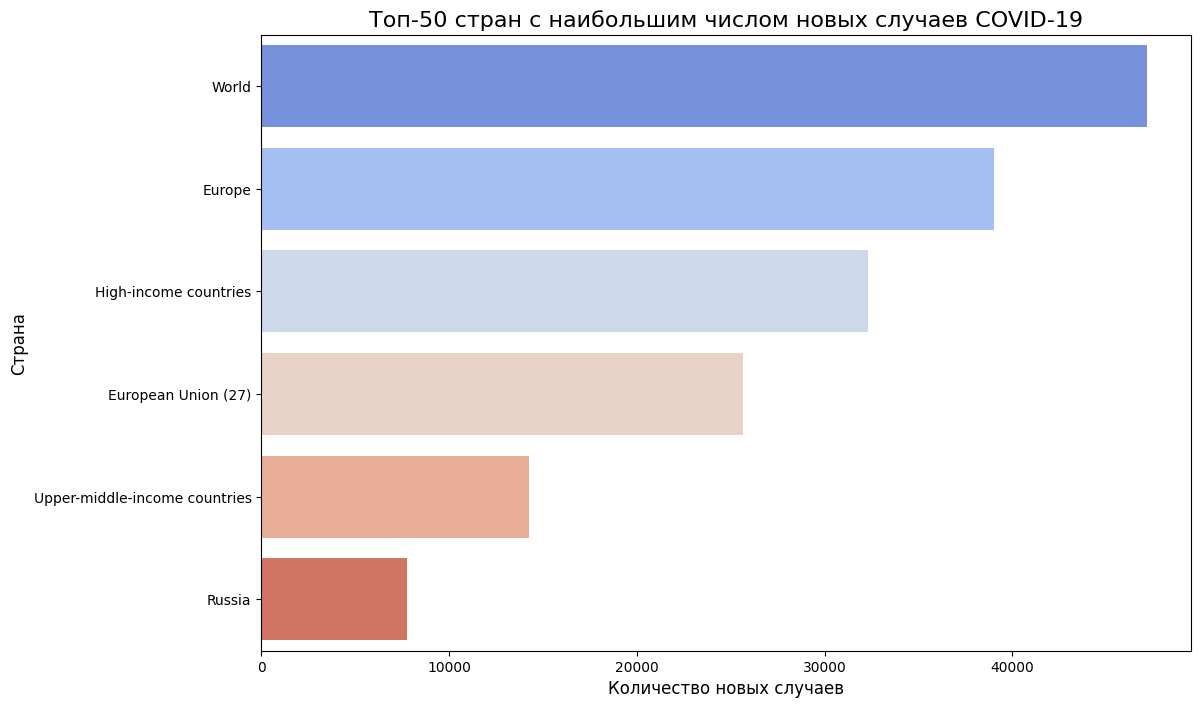

<Figure size 640x480 with 0 Axes>

In [229]:
import matplotlib.pyplot as plt
import seaborn as sns

# Создание папки для сохранения
output_folder = "output_data"
if not os.path.exists(output_folder):
  os.makedirs(output_folder)
  logging.info(f"Создана папка: {output_folder}")

top_countries = pd.read_sql_query(query, conn)

# Построение гистограммы
plt.figure(figsize=(12, 8))
sns.barplot(data=top_countries, x="new_cases", y="location", palette="coolwarm", hue ="location")
plt.title("Топ-50 стран с наибольшим числом новых случаев COVID-19", fontsize=16)
plt.xlabel("Количество новых случаев", fontsize=12)
plt.ylabel("Страна", fontsize=12)
plt.show()

# Сохранение графика
output_path = os.path.join(output_folder, "top_50_countries_new_cases.png")
plt.savefig(output_path, dpi=300)
logging.info(f"График сохранен: {output_path}")

Диаграмма рассеяния: Случаи vs Население:

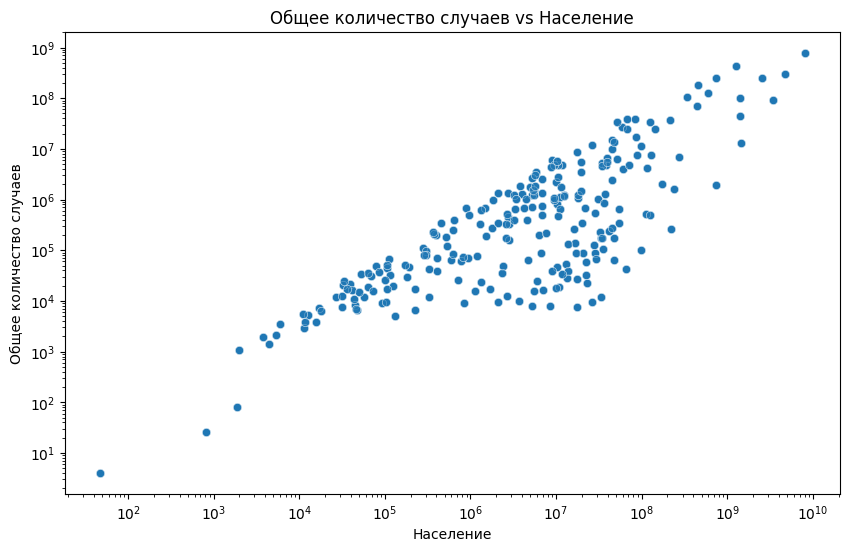

График сохранён: output_data/scatter_population_vs_cases.png


<Figure size 640x480 with 0 Axes>

In [230]:
# Извлечение данных для scatter plot
query = """
SELECT total_cases, population
FROM covid_data
WHERE total_cases IS NOT NULL AND population IS NOT NULL
"""
scatter_data = pd.read_sql_query(query, conn)

# Построение диаграммы рассеяния
plt.figure(figsize=(10, 6))
sns.scatterplot(data=scatter_data, x="population", y="total_cases", alpha=0.6)
plt.title("Общее количество случаев vs Население")
plt.xlabel("Население")
plt.ylabel("Общее количество случаев")
plt.xscale("log")  # Логарифмическая шкала для населения
plt.yscale("log")  # Логарифмическая шкала для случаев
plt.show()

# Сохранение графика
output_path = os.path.join(output_folder, "scatter_population_vs_cases.png")
plt.savefig(output_path, dpi=300)
print(f"График сохранён: {output_path}")

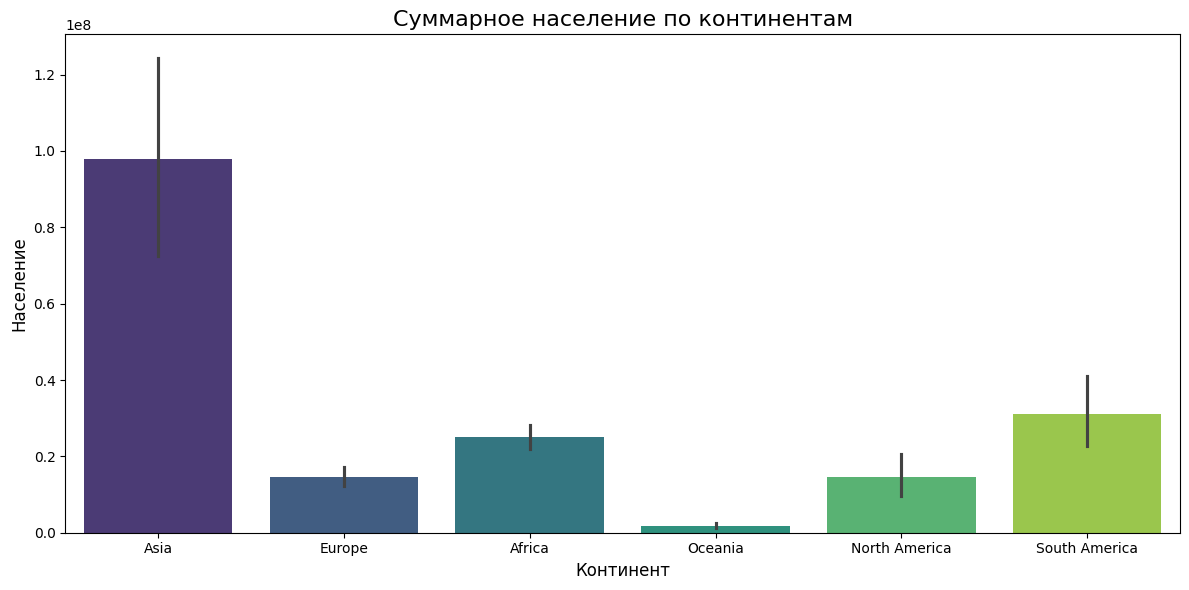

График сохранён: output_data/bar_population_by_continent.png


<Figure size 640x480 with 0 Axes>

In [231]:
# Данные о населении
query = """
SELECT continent, population
FROM covid_data
WHERE continent IS NOT NULL AND population IS NOT NULL
"""
df_population = pd.read_sql_query(query, conn)
# Визуализация с помощью Seaborn
plt.figure(figsize=(12, 6))
sns.barplot(data=df_population, x="continent", y="population", palette="viridis", hue="continent")
plt.title("Суммарное население по континентам", fontsize=16)
plt.xlabel("Континент", fontsize=12)
plt.ylabel("Население", fontsize=12)
plt.tight_layout()
plt.show()

# Сохранение графика
output_path = os.path.join(output_folder, "bar_population_by_continent.png")
plt.savefig(output_path, dpi=300)
print(f"График сохранён: {output_path}")